# Notebook S3 - Alternative profiling methods
Chemical screen, single plate at 750 cells per well.  
In this notebook, we start from the image-level profiles generated in Notebook 2a and identify morphological hits (compounds inducing significant morphological changes compared to DMSO controls), assessed by different methods, and compare them to the approach presented in notebook 2b.

In [1]:
using CSV, StatsBase, Statistics, DataFrames, RCall, FreqTables
using MultipleTesting, Random, MultivariateStats, Distributed
using ParallelDataTransfer
using BioProfiling, UMAP

In [2]:
using Dates: now
now()

2021-11-05T13:26:02.587

In [3]:
# Set the number of processes to use for parallel computing
addprocs(16)
pool = CachingPool(workers())

CachingPool(Channel{Int64}(sz_max:9223372036854775807,sz_curr:16), Set([2, 16, 11, 7, 9, 10, 17, 8, 6, 4, 3, 5, 13, 14, 15, 12]), IdDict{Tuple{Int64,Function},RemoteChannel}())

## R Calls

In [4]:
@rlibrary ggplot2
@rlibrary extrafont
@rlibrary viridis
@rlibrary heatmaply
@rlibrary ggrepel

In [11]:
R"""
# Used later for MCD computation

library(robustbase)

# Customize ggplot appearance

library(ggplot2)
library(extrafont)


# Load extra fonts
ttf_import()
loadfonts()

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), 
                     legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)
"""

┌ Warning: RCall.jl: Scanning ttf files in /usr/share/fonts/ ...
│ Extracting .afm files from .ttf files...
│ /usr/share/fonts/truetype/dejavu/DejaVuMathTeXGyre.ttf => /opt/conda/lib/R/library/extrafontdb/metrics/DejaVuMathTeXGyre
│ /usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf => /opt/conda/lib/R/library/extrafontdb/metrics/DejaVuSans-Bold
│ /usr/share/fonts/truetype/dejavu/DejaVuSans-BoldOblique.ttf => /opt/conda/lib/R/library/extrafontdb/metrics/DejaVuSans-BoldOblique
│ /usr/share/fonts/truetype/dejavu/DejaVuSans-ExtraLight.ttf => /opt/conda/lib/R/library/extrafontdb/metrics/DejaVuSans-ExtraLight
│ /usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf => /opt/conda/lib/R/library/extrafontdb/metrics/DejaVuSans-Oblique
│ /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf => /opt/conda/lib/R/library/extrafontdb/metrics/DejaVuSans
│ /usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Bold.ttf => /opt/conda/lib/R/library/extrafontdb/metrics/DejaVuSansCondensed-Bold
│ /usr/share/fo

RObject{VecSxp}
$repr.plot.width
NULL

$repr.plot.height
NULL



## Load measurements

### Load annotations

In [6]:
annotations = CSV.read("data/transferList.txt", DataFrame, header = 1, delim = "\t")
# Convert plate number to strings to make clear it is an ID and should not be used for computations
annotations[!,:DestinationPlate] = string.(annotations[:,:DestinationPlate])
# Wells in the transfer list without any compound name are filled with DMSO only
annotations[!,:CompoundName][ismissing.(annotations[:,:CompoundName])] .= "DMSO"
# A non-ASCII characters needs to be converted
annotations.CompoundName = replace.(annotations.CompoundName, "\xb1" => s"±");

In [7]:
annotations

,DestWell,SourcePlate_A,SrcWell_A,DestinationPlate,Type_A,VolumeTransferred_A
,String3,String15,String3,String,String7,Int64
1,A01,CLOMP_D4,M04,1914001,Cpd,100
2,A02,CLOUD10mM10,I19,1914001,Cpd,100
3,A03,CLOUD10mM10,A10,1914001,Cpd,100
4,A04,CLOMP002a,L04,1914001,Cpd,100
5,A05,CLOUD10mM10,I05,1914001,Cpd,100
6,A06,CLOMP002a,B11,1914001,Cpd,100
7,A07,CLOMP001a,F15,1914001,Cpd,10
8,A08,CLOMP003a,I20,1914001,Cpd,100
9,A09,CLOUD10mM10,M19,1914001,Cpd,100


### Load image data

In [8]:
image = CSV.read("data/compiled_PilotDrugScreen_Image_750.csv", DataFrame)
println(string.(names(image))[1:8])
# Number of images and features available
println(nrow(image))
println(ncol(image))

LoadError: [91mArgumentError: "data/compiled_PilotDrugScreen_Image_750.csv" is not a valid file or doesn't exist[39m

## Coarse-grain aggregation

In [19]:
aggregatedData = CSV.read("data/aggregatedData_750cells_noSparse.csv", DataFrame);

### Transform aggregated data - Normalization
We want to focus on variables that are changing more overall than inside of reference condition (untreated WT).

In [20]:
expAgg = Experiment(aggregatedData, description = "Median values for aggregated FOV measurements")

"Experiment with 6622/6622 entries and 390/390 features selected."

In [21]:
filters = Array{BioProfiling.AbstractSelector,1}()
# Remove metadata
strToRemove = ["Metadata_Well", "CompoundName", "Metadata_Field", "Metadata_Row", "Metadata_Column"]
push!(filters, NameSelector(x -> !any(occursin.(strToRemove, String(x)))))
# Remove constant columns
push!(filters, Selector(x -> mad(x, normalize = true) != 0, description = "Remove constant features"));
push!(filters, Selector(x -> mad(x, normalize = true) != 0, 
                        subset = x -> x.CompoundName .== "DMSO", 
                        description = "Remove features constant for reference"))
select_features!(expAgg, filters)

In [22]:
expTransformed = deepcopy(expAgg)
logtransform!(expTransformed)
expTransformed.description = "Transformed values for aggregated FOV measurements"

"Transformed values for aggregated FOV measurements"

Here we apply a correction based on the specific details of the experimental design:
All rows and columns include DMSO (negative) controls and we normalize all values based on these matchings controls (same row and column).  

This examplifies how to directly modify the data of an `Experiment` object.  

NB: One might want to check that more iterations are not needed (cf. Median-polish method).

In [23]:
# Normalize on matching DMSO wells median values

# Entries in both data frames are matching
@assert nrow(aggregatedData) == nrow(getdata(expTransformed))

# Copy data before correction
ndf = getdata(expTransformed)

for (i, (fx, fy)) in enumerate(eachrow(aggregatedData[:,[:Metadata_Row, :Metadata_Column]])) 
    c1 = aggregatedData.CompoundName .== "DMSO"
    c2 = aggregatedData.Metadata_Row .== fx
    c3 = aggregatedData.Metadata_Column .== fy
    @assert sum((c1 .& (c2 .| c3))) > 0
    expTransformed.data[i:i, expTransformed.selected_features] .-= 
        mapcols(median, ndf[(c1 .& (c2 .| c3)),:]) 
    expTransformed.data[i:i, expTransformed.selected_features] ./= 
        mapcols(mad, ndf[(c1 .& (c2 .| c3)),:]) 
end

select_features!(expTransformed,
                 Selector(x -> !any(isinf.(x)), 
                        description = "Remove features with infinite values " *
                            "(i.e. with no variation for a subset of the DMSO images)"));

decorrelate_by_mad!(expTransformed);

## PCA + Mahalanobis

In [24]:
pcafit = fit(PCA, Array(getdata(expTransformed)); pratio=0.96)

PCA(indim = 6622, outdim = 2, principalratio = 0.9779271839628244)

In [25]:
umPCA = convert(DataFrame, projection(pcafit))
rename!(umPCA, [:PCA1, :PCA2])
umPCA.Compound = aggregatedData.CompoundName;

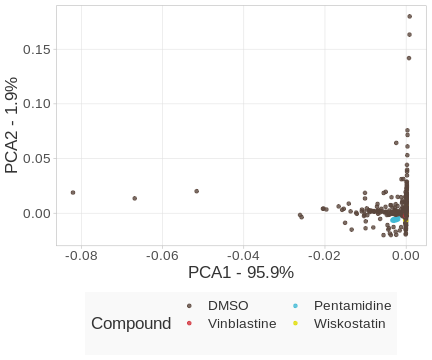

RObject{VecSxp}


In [26]:
subsetCompounds = ["Vinblastine", "Pentamidine", "Wiskostatin", "DMSO"]
subsetEntries = map(x -> x in subsetCompounds, umPCA.Compound)
axlabs = names(umPCA)[1:2] .* " - " .* 
                              string.(round.(100 .* principalvars(pcafit)./tvar(pcafit), digits = 1)) .* "%"
gp = ggplot(umPCA[subsetEntries,:], aes(:PCA1, :PCA2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    xlab(axlabs[1]) + 
    ylab(axlabs[2]) + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))
gp

In [27]:
ggsave("fig/Benchmark_PCA.pdf", gp)

┌ Warning: RCall.jl: Saving 7 x 7 in image
└ @ RCall /opt/julia/packages/RCall/iMDW2/src/io.jl:160


RObject{NilSxp}
NULL


In [ ]:
expPCA = Experiment(umPCA, description = "PCA projection of profiling data")

In [ ]:
filters = Array{BioProfiling.AbstractReduce,1}()
# Remove (categorical) compound column from analysis
push!(filters, NameSelector(x -> x != "Compound"))
# Remove entries for compounds not present often enough
cmpd_to_keep = levels(umPCA.Compound)[freqtable(umPCA.Compound) .>= 8]
compare_in(x,y) = x in y
Broadcast.broadcasted(::typeof(compare_in), x, y) = broadcast(in, x, Ref(y))
push!(filters, Filter(cmpd_to_keep, :Compound, compare = compare_in))
# Apply filters
filter!(expPCA, filters)
expPCA

NB: because the `compare` function of Filter `f` is applied as f.compare.(entries, f.value)
the value provided needs to be of the length of the entries or of length 1.  
Otherwise, when broadcasting (calling `f.compare` on all elements with `f.compare.`), we need to specify that the `f.value` should be used "as is". This is done by overloading the broadcasting of the function. See:   
https://discourse.julialang.org/t/how-to-broadcast-over-only-certain-function-arguments/19274/5  
Another "trick" is to use a function that takes a length 1 value that is in practice not used:  
```julia
push!(filters, Filter("NotUsed", :Compound, compare = (x,y) -> (x in cmpd_to_keep)))
```

In [ ]:
# The following RMD values are displayed in the following order:
selectedCompounds = expPCA.data[expPCA.selected_entries, :Compound]
levels(selectedCompounds)

### Compute "mp-value"

In [ ]:
now()

Takes ~1h20mn with 16 cores

In [ ]:
Random.seed!(3895);

In [ ]:
@everywhere using BioProfiling
plateRMPV = robust_morphological_perturbation_value(expPCA, :Compound, "DMSO"; 
    nb_rep = 5000, dist = :CenterMahalanobis, process_pool = pool)

In [ ]:
now()

In [ ]:
# Missing values might need to be handled
@assert !any(ismissing.(plateRMPV.RMPV))

In [ ]:
# Export to avoid recomputing if not necessary
CSV.write("data/RMPV_PCA.csv", plateRMPV);

In [35]:
plateRMPV_ref = CSV.read("data/RMPV.csv", DataFrame);

## Compare to original space

In [ ]:
expRaw = deepcopy(expTransformed)

In [ ]:
rename!(expRaw.data, :CompoundName => :Compound);

In [ ]:
# Apply filters
filter!(expRaw, filters)
expRaw

In [ ]:
# The following RMD values are displayed in the following order:
selectedCompounds = expRaw.data[expRaw.selected_entries, :Compound]
levels(selectedCompounds)

In [ ]:
Random.seed!(3895);

In [ ]:
println(now())
@everywhere using BioProfiling
plateRMPV_raw = robust_morphological_perturbation_value(expRaw, :Compound, "DMSO"; 
    nb_rep = 5000, dist = :CenterMahalanobis)
println(now())

In [ ]:
# Export to avoid recomputing if not necessary
CSV.write("data/RMPV_raw.csv", plateRMPV_raw);

## Compare hits

In [12]:
plateRMPV = CSV.read("data/RMPV.csv", DataFrame)
plateRMPV.RMPV_PCA = CSV.read("data/RMPV_PCA.csv", DataFrame).RMPV
plateRMPV.RMPV_raw = CSV.read("data/RMPV_raw.csv", DataFrame).RMPV;

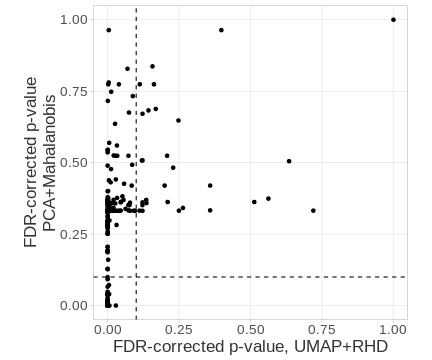

RObject{VecSxp}


In [14]:
gp = ggplot(plateRMPV, aes(x = :RMPV, y = :RMPV_PCA)) +
    geom_point() +
#     ggtitle("Spearman correlation: " * 
#             string(round(
#             corspearman(plateRMPV.RMPV, plateRMPV.RMPV_PCA), digits = 3))) + 
    geom_hline(yintercept = 0.1, lty = 2) +
    geom_vline(xintercept = 0.1, lty = 2) +
    xlab("FDR-corrected p-value, UMAP+RHD") +
    ylab("FDR-corrected p-value\nPCA+Mahalanobis") +
    coord_fixed() +
    RObject(nothing)
gp

In [15]:
ggsave("fig/Benchmark_PCA_RMPV.pdf", gp)

┌ Warning: RCall.jl: Saving 7 x 7 in image
└ @ RCall /opt/julia/packages/RCall/iMDW2/src/io.jl:160


RObject{NilSxp}
NULL


In [16]:
# Number of points in each region of the plot (same order)
freqtable(plateRMPV.RMPV_PCA .< 0.1, plateRMPV.RMPV .> 0.1)

2×2 Named Array{Int64,2}
Dim1 ╲ Dim2 │ false   true
────────────┼─────────────
false       │   192     29
true        │    57      0

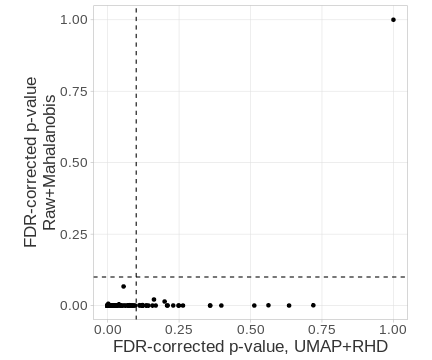

RObject{VecSxp}


In [17]:
gp = ggplot(plateRMPV, aes(x = :RMPV, y = :RMPV_raw)) +
    geom_point() +
#     ggtitle("Spearman correlation: " * 
#             string(round(
#             corspearman(plateRMPV.RMPV, plateRMPV.RMPV_raw), digits = 3))) + 
    geom_hline(yintercept = 0.1, lty = 2) +
    geom_vline(xintercept = 0.1, lty = 2) +
    xlab("FDR-corrected p-value, UMAP+RHD") +
    ylab("FDR-corrected p-value\nRaw+Mahalanobis") +
    coord_fixed() +
    RObject(nothing)
gp

In [18]:
ggsave("fig/Benchmark_Raw_RMPV.pdf", gp)

┌ Warning: RCall.jl: Saving 7 x 7 in image
└ @ RCall /opt/julia/packages/RCall/iMDW2/src/io.jl:160


RObject{NilSxp}
NULL


In [75]:
# Number of points in each region of the plot (same order)
freqtable(plateRMPV.RMPV_raw .< 0.1, plateRMPV.RMPV .> 0.1)

2×2 Named Array{Int64,2}
Dim1 ╲ Dim2 │ false   true
────────────┼─────────────
false       │     0      1
true        │   249     28

Observation: we don't recommmend working with raw measurements because of the curse of dimensionality. Other methods are possible, such as reducing the space with PCA and using other a Mahalanobis distance, which is analogous to the mp-value ([Hutz et al](https://doi.org/10.1177/1087057112469257)). The first axis of such a PCA would recapitulate most of the data variation by itself (panel B). While we don't have a ground truth and what a morphological hit is largely depends on the chosen definition, we observe that despite a significant overlap, the PCA-based approach seems to miss a lot of hits (panel C).  

In [81]:
hitUMAP = plateRMPV.Condition[plateRMPV.RMPV .< 0.1]
hitPCA = plateRMPV.Condition[plateRMPV.RMPV_PCA .< 0.1];

In [82]:
# Jaccard coeff
length(hitUMAP ∩ hitPCA) / length(hitUMAP ∪ hitPCA)

0.2289156626506024

In [83]:
# Total number of compounds
N = 311
# Contingency table 
O = zeros(Int,2,2)
O[1,1] = length(hitPCA ∩ hitUMAP)
O[2,1] = length(hitPCA) - O[1,1]
O[1,2] = length(hitUMAP) - O[1,1]
O[2,2] = N - sum(O)
O

2×2 Array{Int64,2}:
 57  192
  0   62

In [84]:
# Expectation if plates are independent
E = sum.(eachrow(O))./N * (sum.(eachcol(O))./N)'

2×2 Array{Float64,2}:
 0.146742   0.653901
 0.0365381  0.162819

In [85]:
chisq = N*sum((O/N - E).^2 ./E)

17.37776302058628

In [86]:
using Distributions 
# (number of rows - 1)*(number of columns - 1)
ccdf(Chisq(1), chisq)

3.063897053219026e-5

Extra step: compare overlap of features when using other feature selection approach.

## PCA "decorrelation"

In [14]:
expTransformed = deepcopy(expAgg)
logtransform!(expTransformed)
expTransformed.description = "Transformed values for aggregated FOV measurements"

"Transformed values for aggregated FOV measurements"

In [15]:
# Normalize on matching DMSO wells median values

# Entries in both data frames are matching
@assert nrow(aggregatedData) == nrow(getdata(expTransformed))

# Copy data before correction
ndf = getdata(expTransformed)

for (i, (fx, fy)) in enumerate(eachrow(aggregatedData[:,[:Metadata_Row, :Metadata_Column]])) 
    c1 = aggregatedData.CompoundName .== "DMSO"
    c2 = aggregatedData.Metadata_Row .== fx
    c3 = aggregatedData.Metadata_Column .== fy
    @assert sum((c1 .& (c2 .| c3))) > 0
    expTransformed.data[i:i, expTransformed.selected_features] .-= 
        mapcols(median, ndf[(c1 .& (c2 .| c3)),:]) 
    expTransformed.data[i:i, expTransformed.selected_features] ./= 
        mapcols(mad, ndf[(c1 .& (c2 .| c3)),:]) 
end

select_features!(expTransformed,
                 Selector(x -> !any(isinf.(x)), 
                        description = "Remove features with infinite values " *
                            "(i.e. with no variation for a subset of the DMSO images)"));

In [16]:
pcafit = fit(PCA, Array(getdata(expTransformed)); pratio=0.995)

PCA(indim = 6622, outdim = 48, principalratio = 0.99509366240654)

In [28]:
pcaproj = convert(DataFrame, projection(pcafit))

rename!(pcaproj, Symbol.("PCA" .* string.(1:outdim(pcafit))));

In [29]:
expPCA = Experiment(pcaproj, description = "PCA projection of correlated data")

"Experiment with 6622/6622 entries and 48/48 features selected."

In [31]:
using Distances

In [34]:
Random.seed!(3895)
umPCA = umap(expPCA, metric = CosineDist(), min_dist = 2)
umPCA = convert(DataFrame, umPCA')
rename!(umPCA, [:UMAP1, :UMAP2]);
umPCA.Compound = aggregatedData.CompoundName;

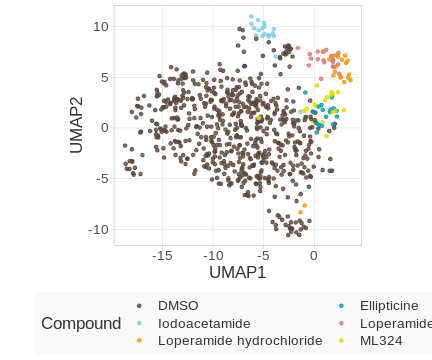

RObject{VecSxp}


In [35]:
subsetCompounds = ["Iodoacetamide", "Ellipticine", "Loperamide", "DMSO", "ML324"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umPCA.Compound), subsetCompounds)))[1])
ggplot(umPCA[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

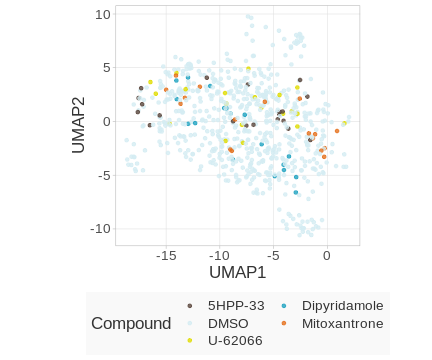

RObject{VecSxp}


In [36]:
subsetCompounds = ["Mitoxantrone", "U-62066", "5HPP-33", "DMSO", "Dipyridamole"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umPCA.Compound), subsetCompounds)))[1])
ggplot(umPCA[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))

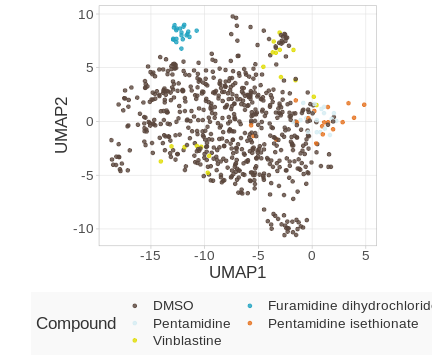

RObject{VecSxp}


In [37]:
subsetCompounds = ["Vinblastine", "Pentamidine", "Furamidine", "DMSO"]
subsetEntries = Bool.(map(sum, eachcol(map(x -> occursin.(x, umPCA.Compound), subsetCompounds)))[1])
ggplot(umPCA[subsetEntries,:], aes(:UMAP1, :UMAP2)) + 
    geom_point(aes(color = :Compound), alpha = 0.8) +
    coord_fixed() + 
    theme(var"legend.position"="bottom", var"legend.spacing.x" = unit(0.35, "cm"), 
    var"legend.spacing.y" = unit(0, "cm")) + 
    guides(color=guide_legend(nrow=3,byrow=true))